# Day 4: Demand I - Enhancing the model with demand

We will continue our modeling exercise by including demand responses.

This will allow us to consider the policy impacts of alternative energy transition policies, when consumers face different pricing regimes.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries, same as last session.

In [1]:
#using Pkg
#Pkg.add(["DataFrames", "CSV", "JuMP", "Ipopt", "Cbc", "Plots", "Printf"])

In [46]:
using DataFrames
using CSV
using JuMP
using Ipopt, Cbc
using Plots
using Printf

## Building the model

We load the same data as usual, and also clean it up to simplify it further and create the demand and import curves.

In [47]:

dfclust = CSV.read("data_jaere_clustered.csv", DataFrame);

# Re-scaling (we multiply by 8.76 to make it into a full year of hours (divided by 1000))
dfclust.weights = 8.76 * dfclust.weights / sum(dfclust.weights);

# Here only one demand type to make it easier
dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

# Calibrate imports (using elas 0.3)
dfclust.bm = 0.3 * dfclust.imports ./ dfclust.price;  # slope
dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept
    
describe(dfclust)



,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,price,38.5055,1.66311,37.2797,137.116,0,Float64
2,imports,7.52426,4.2479,7.57055,9.79814,0,Float64
3,q_commercial,12.9532,9.26236,12.3881,22.1766,0,Float64
4,q_industrial,4.1224,2.60049,3.83347,7.62003,0,Float64
5,q_residential,11.0753,4.3995,10.0075,20.4922,0,Float64
6,wind_cap,0.340955,0.0935896,0.334676,0.681777,0,Float64
7,solar_cap,0.260549,0.00155919,0.0679638,0.793407,0,Float64
8,hydronuc,5.0346,2.36316,4.56859,9.68051,0,Float64
9,weights,0.0876,0.00787044,0.0788053,0.227839,0,Float64


We also load the technology file

In [48]:
tech = CSV.read("data_technology.csv", DataFrame);
afactor = (1 - (1 / (1.05^20.0))) / 0.05;
tech.F = tech.F ./afactor;
tech.F2 = tech.F2 ./afactor;
tech

,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0
5,New Gas,6.6,0.0,78.4773,0.0,100.0,1,0
6,Wind,0.0,0.0,100.303,0.0,100.0,1,1
7,Solar,0.0,0.0,100.303,0.0,100.0,1,1


### Adding demand considerations

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs - Fixed Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

To include demand, we will separate the price that consumers pay from the price that the wholesale market sets. We define a variable "tariff" that is what consumers pay any hour of the day.

We also allow alpha to determine the share of "insensitive" consumers. We can see how the investment changes as we modify "alpha".

In [223]:
function clear_market_invest_tariff(data::DataFrame, tech::DataFrame;
    subsidy=0.0, tax=0.0, elas = 0.1, tariff= 40.0, alpha=1.0, ng_price = 4.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods

    # gas prices
    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end

    # Setting demand parameters
    data.b = elas * data.demand ./ data.price;  # slope
    data.a = data.demand + data.b .* data.price;  # intercept
    
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, costs[1:T]);
    @variable(model, total_cost);
    @variable(model, gross_surplus[1:T]);
    @variable(model, 0.0 <= gas_gw <= 20.0);
    @variable(model, 0.0 <= wind_gw <= 20.0);
    @variable(model, 0.0 <= solar_gw <= 20.0);

    
    # Maximize welfare including imports costs
    @NLobjective(model, Max, sum(data.weights[t] * gross_surplus[t] for t=1:T) - total_cost);

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * (alpha*tariff + (1.0-alpha)*price[t]));
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    data.ahat = data.a - alpha * data.b * tariff - data.am;
    data.bhat = (1-alpha)*data.b + data.bm; 
    @constraint(model, [t=1:T], gross_surplus[t]==
        # demand after accounting for imports and insensitive consumers
            (price[t] * (data.ahat[t] - data.bhat[t]*price[t]) + (data.ahat[t] - data.bhat[t]*price[t])^2/(2*data.bhat[t])));

    # Define costs
    @constraint(model, [t=1:T], costs[t] ==
        sum(tech.c[i] * quantity[t,i] + tech.c2[i] * quantity[t,i]^2/2 + tax * tech.e[i] * quantity[t,i] - subsidy * tech.renewable[i] * quantity[t,i] for i = 1:I));
    @constraint(model, total_cost == sum(data.weights[t] * costs[t] for t=1:T) + tech.F[5]*gas_gw  + tech.F[6]*wind_gw + tech.F[7]*solar_gw);

    # Constraints on output
    @constraint(model, [t=1:T], 
        quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= gas_gw);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= solar_gw * data.solar_cap[t]);

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        d = JuMP.value.(demand);
        d_insen = (data.a .- data.b.*tariff);
        d_sen = (data.a .- data.b.*p);
        avg_price = sum(p.*d.*data.weights)/sum(d.*data.weights);
        avg_price_insen = sum(p.*d_insen.*data.weights)/sum(d_insen.*data.weights);
        avg_price_sen = sum(p.*d_sen.*data.weights)/sum(d_sen.*data.weights);
        imp = JuMP.value.(imports);
        q = JuMP.value.(quantity);
        cost = JuMP.value.(costs);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "avg_price_insen" => avg_price_insen,
            "avg_price_sen" => avg_price_sen,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "total_cost" => JuMP.value.(total_cost),
            "gas_gw" => JuMP.value.(gas_gw),
            "wind_gw" => JuMP.value.(wind_gw),
            "solar_gw" => JuMP.value.(solar_gw));
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        @printf("Solving error!")
        return results
    end

end

clear_market_invest_tariff (generic function with 1 method)

We will set the initial tariff to $40/MWh.

In [224]:
results1 = clear_market_invest_tariff(dfclust, tech, tariff=30.0)

Dict{String, Any} with 13 entries:
  "avg_price"       => 36.7112
  "price"           => [44.946, 39.3527, 29.8912, 43.9236, 30.3936, 35.4592, 30…
  "gas_gw"          => 3.95191
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 5.12995e-8 2.54701e-9; 4.0713 11.5 … 4.3…
  "solar_gw"        => -9.91972e-9
  "imports"         => [8.91861, 8.42526, 8.22304, 7.23699, 5.82876, 7.7231, 8.…
  "avg_price_sen"   => 35.7042
  "demand"          => [38.8695, 28.1024, 27.5022, 30.5235, 22.5907, 26.1582, 2…
  "avg_price_insen" => 36.7112
  "cost"            => [742.362, 482.575, 415.24, 644.969, 417.299, 465.649, 44…
  "total_cost"      => 4516.2
  "wind_gw"         => 1.33393e-7

Notice that average weighted prices are higher than the tariff we charged consumers, we need to charge them more or otherwise, we would not be able to pay the producers of energy.

In [225]:
results2 = clear_market_invest_tariff(dfclust, tech, tariff=70.0)

Dict{String, Any} with 13 entries:
  "avg_price"       => 38.9359
  "price"           => [45.2335, 39.2413, 29.7886, 43.4933, 30.6557, 30.7802, 3…
  "gas_gw"          => 0.856303
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 2.96582e-8 2.55444e-9; 4.0713 11.5 … 2.6…
  "solar_gw"        => -9.91948e-9
  "imports"         => [8.93388, 8.41745, 8.21503, 7.21195, 5.84177, 7.35422, 8…
  "avg_price_sen"   => 33.5228
  "demand"          => [36.0402, 24.9016, 24.1227, 27.027, 20.2132, 22.2046, 23…
  "avg_price_insen" => 38.9359
  "cost"            => [671.957, 397.025, 325.282, 546.819, 357.096, 368.826, 3…
  "total_cost"      => 3584.24
  "wind_gw"         => 6.51981e-8

We can see the right tariff is between \\$35 and \\$50/MWh.

### Solving for the fixed point
We can solve for the fixed point in a loop.

In [226]:
current_diff = 1.0;
guess = 47.0;
while (current_diff > 1e-2)
    res = clear_market_invest_tariff(dfclust, tech, tariff=guess);
    newguess = res["avg_price_insen"];
    current_diff = (guess-newguess).^2;
    guess = newguess;
end
guess


36.90820561306032

Note: It is best to convert this into a function so that now we can compare alternative solutions.

In [227]:
function clear_market_equilibrium(data::DataFrame, tech::DataFrame; 
        tariff=43.0, alpha=1.0, tax=0.0, subsidy=0.0, elas = 0.1)
    
    current_diff = 1.0;
    guess = tariff;
    while (current_diff > 1e-3)
        res = clear_market_invest_tariff(dfclust, tech, tariff=guess, alpha=alpha,
            tax=tax, subsidy=subsidy,  elas=elas);
        newguess = res["avg_price_insen"];
        current_diff = (guess-newguess).^2;
        guess = newguess;
    end
    
    # we solve at the equilibrium guess and save tariff
    res = clear_market_invest_tariff(dfclust, tech, tariff=guess, alpha=alpha,
            tax=tax, subsidy=subsidy);
    res["tariff"] = guess;
    
    return res
    
end

clear_market_equilibrium (generic function with 1 method)

In [228]:
res_sen = clear_market_equilibrium(dfclust, tech)

Dict{String, Any} with 14 entries:
  "avg_price"       => 36.9077
  "price"           => [45.0035, 39.3412, 29.8761, 43.857, 30.4415, 33.6715, 30…
  "gas_gw"          => 3.41007
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 3.96618e-8 2.54995e-9; 4.0713 11.5 … 3.4…
  "solar_gw"        => -9.91939e-9
  "tariff"          => 36.908
  "imports"         => [8.92166, 8.42445, 8.22186, 7.23312, 5.83114, 7.58217, 8…
  "avg_price_sen"   => 35.3755
  "demand"          => [38.3809, 27.5497, 26.9186, 29.9197, 22.1801, 25.4754, 2…
  "avg_price_insen" => 36.9077
  "cost"            => [730.314, 467.872, 399.721, 628.113, 406.914, 451.344, 4…
  "total_cost"      => 4356.0
  "wind_gw"         => 9.67309e-8

In [229]:
res_insen = clear_market_equilibrium(dfclust, tech, alpha=0.9, tax=15.0, tariff=43.0)

Dict{String, Any} with 14 entries:
  "avg_price"       => 39.2816
  "price"           => [50.234, 36.0643, 35.4465, 50.0747, 34.1247, 37.2396, 34…
  "gas_gw"          => -3.66602e-10
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 5.4627 2.63907e-9; 4.0713 10.6917 … 4.41…
  "solar_gw"        => -9.90938e-9
  "tariff"          => 39.4488
  "imports"         => [9.19954, 8.19478, 8.65684, 7.59495, 6.01404, 7.86347, 8…
  "avg_price_sen"   => 37.8243
  "demand"          => [38.1249, 27.3734, 26.7377, 29.6047, 22.0608, 25.2461, 2…
  "avg_price_insen" => 39.4488
  "cost"            => [610.35, 405.06, 371.99, 545.661, 209.586, 423.45, 213.8…
  "total_cost"      => 4783.53
  "wind_gw"         => 17.2005

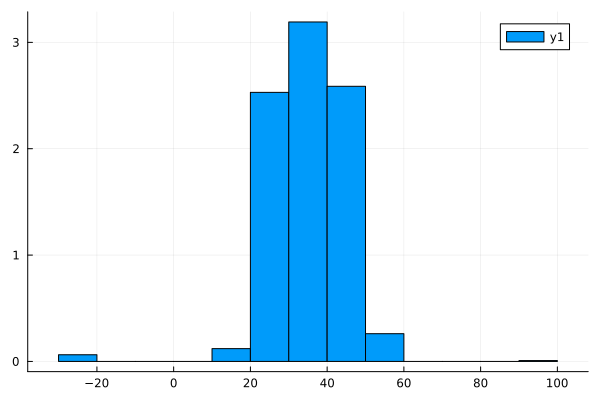

In [230]:
histogram(res_sen["price"], weights=dfclust.weights)

## Does it help to have attentive consumers?

We visualize the impact of the policy.

We can plot the costs (or prices) of electricity for several values of alpha. This can take a while to compute.

In [231]:
begin
    
    share_alpha = collect(0.0:0.2:1.0);
    tax = collect(0.0:5.0:25.0);
    
    dataPolicy = DataFrame(alpha=Float64[], tax=Float64[], tariff=Float64[], 
        total_cost=Float64[], rnw_gw=Float64[]);
    
    for a in share_alpha
        for t in tax
            res = clear_market_equilibrium(dfclust, tech, 
                tariff=40.0, alpha=a, tax=t, elas=0.1);
            push!(dataPolicy, [a, t, res["tariff"], res["total_cost"], res["wind_gw"]+res["solar_gw"]]);
        end
    end
    
end

In [232]:
dataPolicy

,alpha,tax,tariff,total_cost,rnw_gw
,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,36.6909,4373.97,2.20163e-7
2,0.0,5.0,38.3087,4525.11,11.9396
3,0.0,10.0,38.4731,4684.99,15.3919
4,0.0,15.0,38.9323,4810.2,18.4058
5,0.0,20.0,39.9424,4892.57,20.0
6,0.0,25.0,41.6727,4936.12,20.0
7,0.2,0.0,36.7199,4370.58,1.72409e-7
8,0.2,5.0,38.3672,4520.82,11.0879
9,0.2,10.0,38.6087,4677.63,15.1402


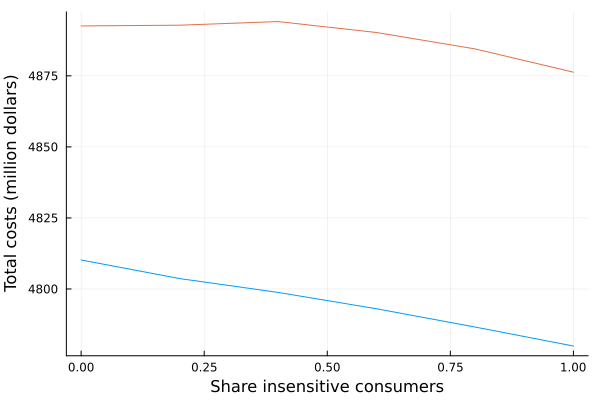

In [233]:
let
    
    tax1 = dataPolicy[dataPolicy.tax.==15.0,:]
    tax2 = dataPolicy[dataPolicy.tax.==20.0,:]
    
    plot(tax1.alpha, tax1.total_cost, legend = false)
    plot!(tax2.alpha, tax2.total_cost, legend = false)
    plot!(xlab="Share insensitive consumers",ylab="Total costs (million dollars)")
    
end

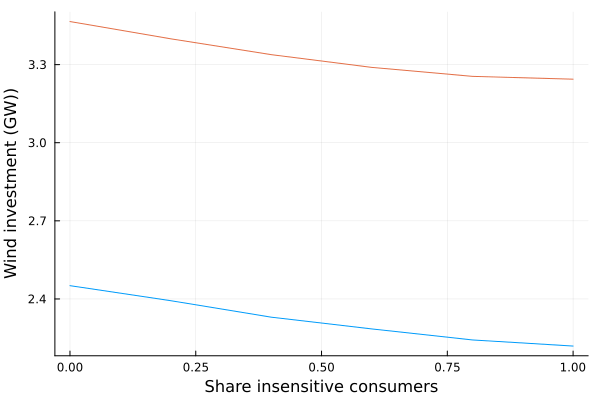

In [209]:
let
    
    tax1 = dataPolicy[dataPolicy.tax.==10.0,:]
    tax2 = dataPolicy[dataPolicy.tax.==15.0,:]
    
    plot(tax1.alpha, tax1.rnw_gw, legend = false)
    plot!(tax2.alpha, tax2.rnw_gw, legend = false)
    plot!(xlab="Share insensitive consumers",ylab="Wind investment (GW))")
    
end

## Follow-up exercises

1. What take aways do you get from the above visualization?

2. Consider an energy savings technology. How could it be added to the model? What would be the challenges in calibrating it?
3. Assume that consumers only pay attention to the average price instead of the real wholesale price, although they keep paying the later. Let the average price equal to the tariff. How would you change your model?